<a id='head'></a>

# Определение стоимости автомобилей

## Оглавление
 
- [**Введение**](#intro)
    - [Входные данные](#input_data)
    - [Ход исследования](#progress)
    
- [**1. Обзор данных**](#part_1)
    - [1.1 Импорт библиотек](#part_1_1)
    - [1.2 Обзор данных](#part_1_2)
    - [Выводы](#part_1_conclusions)

- [**2. Предобработка данных**](#part_2)
    - [2.1 Удаление лишних для модели столбцов](#part_2_1)
    - [2.2 Чистка данных](#part_2_2)
    - [2.3 Обзор очищенного массива](#part_2_3)
    - [Выводы](#part_2_conclusions)

- [**3. Подготовка данных**](#part_3)
    - [3.1 Кодирование категориальных признаков](#part_3_1)
    - [3.2 Разбивка датасета на выборки](#part_3_2)

- [**4. Обучение моделей**](#part_4)
    - [4.1 Подготовка к обучению](#part_4_1)
    - [4.2 Decision Tree Regressor](#part_4_2)
    - [4.3 XGBoost](#part_4_3)
    - [4.4 Light GBM](#part_4_4)
    - [4.5 CatBoost](#part_4_5)
    - [4.6 Проверка моделей на адекватность](#part_4_6)
    
- [**5. Анализ моделей**](#part_5)
    - [5.1 Анализ на этапах предобработки](#part_5_1)
    - [5.2 Анализ финальных моделей](#part_5_2)
    - [5.3 Тестирование лучшей модели](#part_5_3)
    - [Выводы](#part_5_conclusions)

- [Чек лист](#check_list)

<a id='intro'></a>
# Введение [▴](#head)

Сервис по продаже автомобилей с пробегом **«Не бит, не крашен»** разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

Требуется построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

### Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

<a id='input_data'></a>
## Входные данные [▴](#head)

Данные находятся в файле `/datasets/autos.csv`

### Признаки:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

### Целевой признак:
- `Price` — цена (евро)

<a id='progress'></a>
## Ход исследования [▴](#head)

1. Загрузка данных, путь к файлу: `/datasets/autos.csv`
2. Изучение и обработка данных:
    - Обработка пропущенных значений;
    - Обработка аномалий;
    - Определение неинформативных столбцов для модели.
3. Подготовка выборок для обучения моделей.
4. Тестирование разных моделей обучения, с учетом подбора гиперпараметров:
    - `XGBoost`
    - `LightGBM`
    - `CatBoost`
    - `DecisionTree`
5. Анализ следующих метрик качества моделей:
    - время обучения;
    - время предсказания;
    - качество моделей;
6. Выбор лучшей модели, основываясь на критериях заказчика, проверка модели на тестовой выборке.

<a id='part_1'></a>
# 1. Обзор данных [▴](#head)

<a id='part_1_1'></a>
## 1.1 Импорт библиотек и данных [▴](#head)

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### Импорт данных

In [2]:
# для того чтобы код работал локально и на Практикуме применим конструкцию try-except

try: # локально
    df_raw = pd.read_csv('datasets/autos.csv')
except: # для Практикума
    df_raw = pd.read_csv('/datasets/autos.csv')

### Установка параметров

In [3]:
plt.rcParams.update({'font.size':15}) # зададим размер шрифта по умолчанию для графиков

<a id='part_1_2'></a>
## 1.2 Обзор данных [▴](#head)

Для предварительного обзора данных используем заранее заготовленную функцию

In [4]:
def overview(o_df):
    print('\nОбщий вид')
    display(o_df.head())
    
    print('\n.info()\n')
    o_df.info()

    df_i = o_df.isna().sum().index
    
    print('\nКоличество полных дубликатов:', o_df.duplicated().sum())
        
    df_na_sum = o_df.isna().sum().values
    df_na_part = round(o_df.isna().sum() / o_df.shape[0] * 100, 1).values
    display(pd.DataFrame({'Количество пропусков': df_na_sum, 'Процент пропусков %': df_na_part}, index=df_i)) 
    
    print('\n.describe(числовых значений датафрейма)')
    display(o_df.describe())
    
    print('\n.describe(категориальных значений и дат)')
    display(o_df.select_dtypes(include=['object', 'datetime']).describe())
    
    plt.figure(figsize=(12,10))
    corr_matrix = sns.heatmap(o_df.corr(), 
                              annot=True, 
                              vmin=-1, vmax=1, center=0, 
                              cmap='coolwarm',
                              mask=(np.tri(len(o_df.corr())).T),
                              linewidths=1,
                              linecolor='grey')
    
    corr_matrix.set_title("Корреляционная матрица", fontsize=16)
    plt.show()


Общий вид


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7

,Количество пропусков,Процент пропусков %
DateCrawled,0,0.0
Price,0,0.0
VehicleType,37490,10.6
RegistrationYear,0,0.0
Gearbox,19833,5.6
Power,0,0.0
Model,19705,5.6
Kilometer,0,0.0
RegistrationMonth,0,0.0
FuelType,32895,9.3



.describe(числовых значений датафрейма)


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



.describe(категориальных значений и дат)


,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


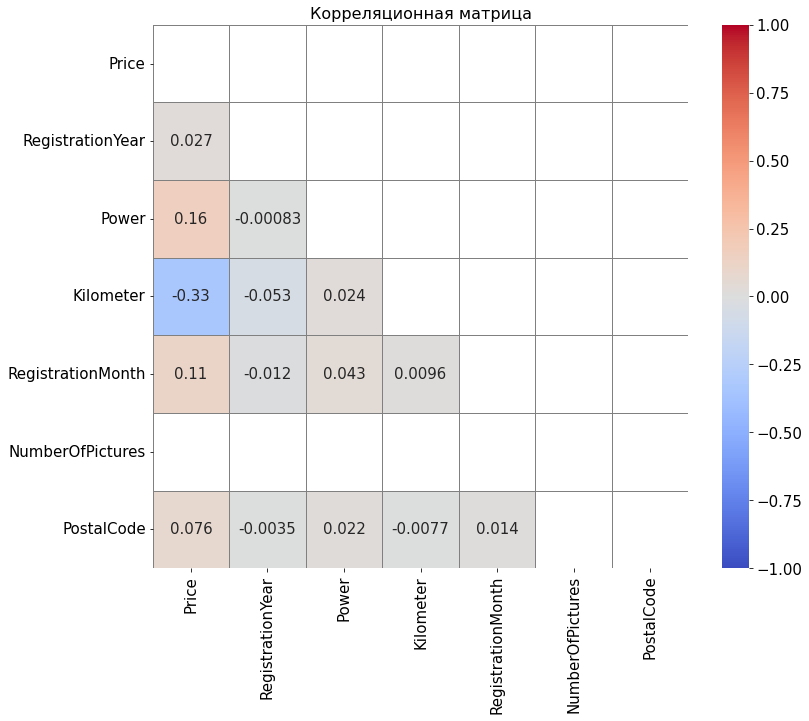

In [5]:
overview(df_raw)

<a id='part_1_conclusions'></a>
## Выводы [▴](#head)

Видно, что входные данные крайне грязные. Вот что удалось подметить:

- `Price` - Минимальное значение 0, что никак не вписывается для продажи автомобилей
- `VehicleType` - Количество пропусков 37 тыс., 10% от датафрейма
- `RegistrationYear` - Аномальные значения от 1000 до 9999
- `Gearbox` - 19 тыс пропусков, 5% от датафрейма
- `Power` - Аномальные значения от 0 до 20 тыс.
- `Model` - 19 тыс пропусков, 5% от датафрейма
- `FuelType` - 30 тыс. пропусков, 9% от датафрейма
- `NotRepaired` - 70 тыс. пропусков, 20% от датафрейма

По итогу матрица корреляции получилась абсолютно неинформативная. Хотя даже на таких грязных данных видим существенную отрицательную корреляцию цены в зависимости от пробега автомобиля.

Количество полных дубликатов - `4`. Еще раз выполним такую проверку после предобработки.

Учитывая загрязненность данных, считаю лучшим решением разобрать кадый столбец по отдельности.

<a id='part_2'></a>
# 2. Предобработка данных [▴](#head)

<a id='part_2_1'></a>
## 2.1 Удаление лишних для модели признаков [▴](#head)

Для начала определим, какие данные будут для модели обучения "мусорными":

Столбец|Описание|Комментарий
-|-|-
**`DateCrawled`**|Дата скачивания анкеты из базы | Дата скачивания анкеты ничего не скажет нашей модели
**`RegistrationMonth`**|Месяц регистрации автомобиля| Месяц регистрации автомобиля не сильно повлияет на стоисмость, намного важнее год, его мы и оставим, а вот месяц сотрем
**`DateCreated`**|Дата создания анкеты | Дата создания анкеты тоже является неинформативной
**`NumberOfPictures`**|Количество фотографий автомобиля | Количество фотографий никак не влияет на стоимость
**`PostalCode`**|Почтовый индекс владельца анкеты (пользователя) | В текущем виде ничего не говорит для нашей модели.
**`LastSeen`**|Дата последней активности пользователя | Никак не влияет на стоимость авто



Теперь очистим наш датафрейм.

Для начала создадим список столбцов для удаления.

In [6]:
columns_to_drop = [
    'DateCrawled',
    'RegistrationMonth',
    'DateCreated',
    'NumberOfPictures',
    'PostalCode',
    'LastSeen'
]

Создаем рабочий датафрейм **`df`** без лишних столбцов.

In [7]:
df = df_raw.drop(columns=columns_to_drop).copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Теперь признаки выглядят более вменяемо для нашей модели. Приступим к очистке.

<a id='part_2_2'></a>
## 2.2 Чистка данных [▴](#head)

Для начала напишем функцию для анализа значений в столбце

**Функция принимает:**
- `датафрейм`
- `имя столбца`
- `размер шрифта для графиков (опционально)`

**Возвращает:**
- Если введено `неверное` имя столбца: актуальный список столбцов датафрейма
- Если данные в с толбце имеют тип `object`: набор информации для анализа текстовых значений
- Иначе: набор информации для анализа `числовых` данных

In [8]:
def analysis(df_name, df_colname, label_sizer=18):
    
    if df_colname not in df_name.columns:
        print(df.columns)
    
    elif df[df_colname].dtype == 'object':
        plt.figure(figsize=(20,0.1))
        plt.title(f'Анализ столбца - {df_colname}', {'fontsize': 30})
        plt.axis('off')
        plt.show()
    
        print(f'Тип данных в столбце: {df_name[df_colname].dtypes}\n\n')
        print(f'Количество пропусков: {df_name[df_colname].isna().sum()}')
        print(f'Доля пропусков: {df_name[df_colname].isna().sum() / df_name.shape[0]:.1%}\n\n')
        print(f'.describe()\n{df_name[df_colname].describe()}\n\n')
        print(f'Количество упоминаний:\n{df_name[df_colname].value_counts(dropna=False)}')    
        
        plt.figure(figsize=(15,7))
        sns.barplot(y=df_name[df_colname].fillna('NaN').value_counts(dropna=False).index, 
                    x=df_name[df_colname].value_counts(dropna=False).values, 
                    orient='h')
        plt.title(f'Количество упоминаний - {df_colname}')
        plt.grid()
        plt.tick_params(axis='y', which='major', labelsize=label_sizer)
        plt.show()
    
    else:
        plt.figure(figsize=(20,0.1))
        plt.title(f'Анализ столбца - {df_colname}', {'fontsize': 30})
        plt.axis('off')
        plt.show()
        
        print(f'Тип данных в столбце: {df_name[df_colname].dtypes}\n')
        print(f'Количество пропусков: {df_name[df_colname].isna().sum()}')
        print(f'Доля пропусков: {df_name[df_colname].isna().sum() / df_name.shape[0]:.1%}\n\n')
        print(f'.describe()\n{df_name[df_colname].describe()}\n\n')
        print(f'Количество уникальных значений:\n{df_name[df_colname].value_counts(dropna=False)}')
             
        plt.figure(figsize=(15,7))
        sns.histplot(df_name[df_colname], bins=30)
        plt.title(f'Гистограмма - {df_colname}')
        plt.grid()
        plt.show()
        
        plt.figure(figsize=(15,2))
        plt.boxplot(df_name[df_colname], vert=False, labels=[''])
        plt.grid()
        plt.title(f'Диаграмма размаха - {df_colname}')
        plt.xlabel(df_colname)
        plt.show()

Функция подсчета доли среза данных в изначальном датафрейме

In [9]:
def part_calc(df_slice):
    print(f'Количество: {df_slice.shape[0]}')
    print(f'Доля от изначального датасета: {df_slice.shape[0] / df_raw.shape[0]:.2%}\n')

----

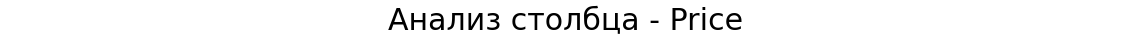

Тип данных в столбце: int64

Количество пропусков: 0
Доля пропусков: 0.0%


.describe()
count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64


Количество уникальных значений:
0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: Price, Length: 3731, dtype: int64


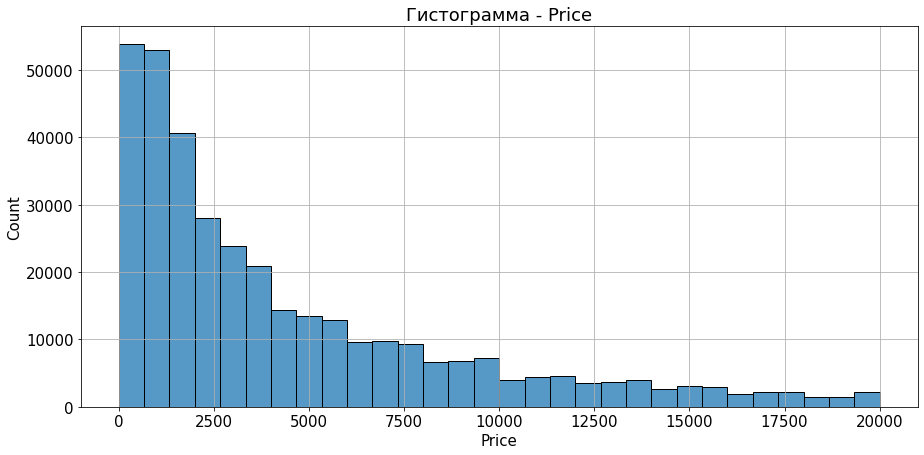

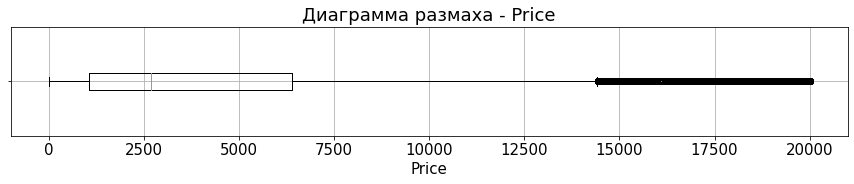

In [10]:
analysis(df, 'Price')

Видно, что есть нулевые значения, причем в огромном количестве, что невозможно для текущей задачи. 

Диаграмма размаха показывает, что значения выше `15000` похожи на выбросы. Но `20000` вполне приемлемая цена за автомобиль. По этому верхнее значение трогать не будем.

Взглянем подробнее на значения ниже `500`

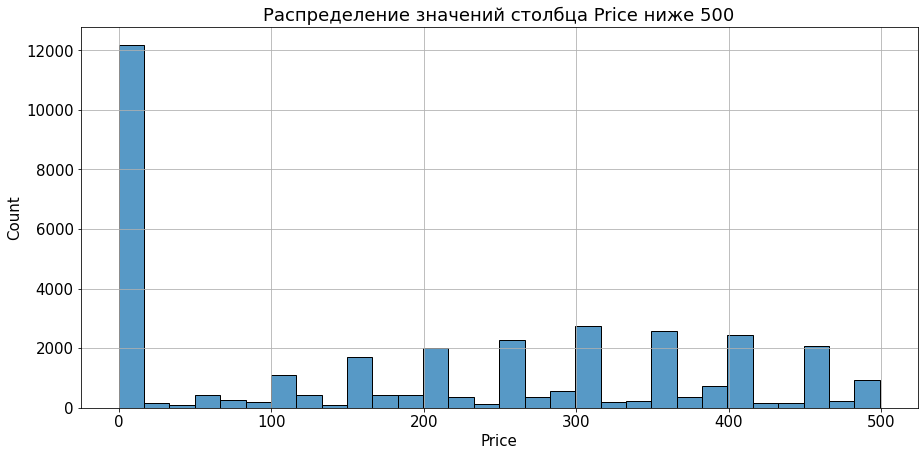

In [11]:
plt.figure(figsize=(15,7))
sns.histplot(df[df['Price'] < 500]['Price'], bins=30)
plt.title('Распределение значений столбца Price ниже 500')
plt.grid()
plt.show()

Видно, что после всплеска на отметке в `100` евро, значения идут в разнобой плюс в крайне малом количестве. После чего упираются в `0`, что является аномалией. Считаю, что заполнять аномалию каким либо значением в данной ситуации было бы неверным. Просто удалим эти данные, а минимальную цену за авто оставим на значении в `100` евро.

Но cначала вычислим долю значений

In [12]:
part_calc(df[df['Price'] < 100])

Количество: 13314
Доля от изначального датасета: 3.76%



`3.7%` вполне приемлемое значение.

Удалим значения `Price` ниже `100` евро

In [13]:
df = df.drop(df[df['Price'] < 100].index)

-----

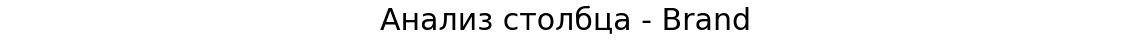

Тип данных в столбце: object


Количество пропусков: 0
Доля пропусков: 0.0%


.describe()
count         341055
unique            40
top       volkswagen
freq           73933
Name: Brand, dtype: object


Количество упоминаний:
volkswagen        73933
opel              38178
bmw               35556
mercedes_benz     31197
audi              28415
ford              24207
renault           17238
peugeot           10706
fiat               9262
seat               6682
mazda              5439
skoda              5422
smart              5149
citroen            4984
nissan             4776
toyota             4525
hyundai            3517
mini               3159
volvo              3106
mitsubishi         2907
honda              2702
sonstige_autos     2700
kia                2397
suzuki             2257
alfa_romeo         2211
chevrolet          1697
chrysler           1354
dacia               888
daihatsu            761
subaru              722
porsche             705
jeep                652
land_r

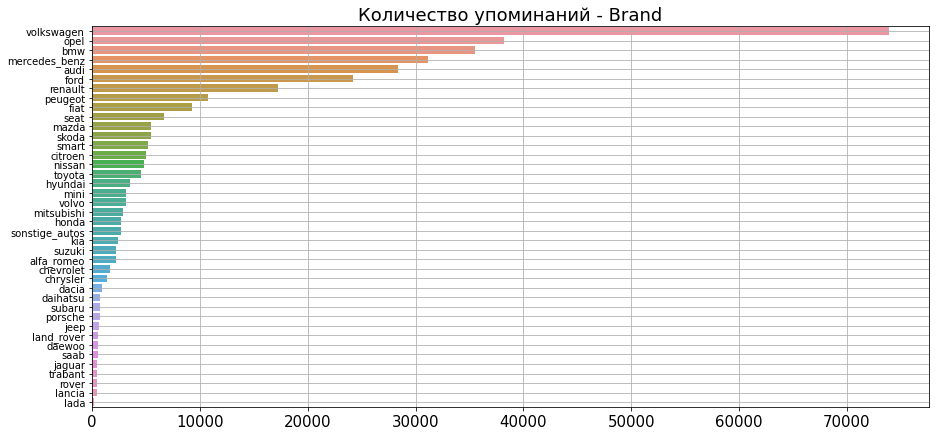

In [14]:
analysis(df, 'Brand', 10)

В столбце **`Brand`** отсутствуют аномалии и пропущенные значения. Этот столбец не нуждается в обработке.

Так же мы видим, что подавляющее количество автомобилей от брендов немецких автопроизводителей. Учитывая цену в евро, можно предположить, что датасет с немецкого автомобильного рынка.

-----

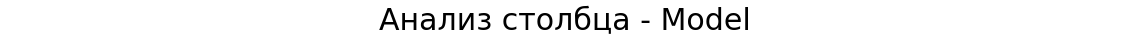

Тип данных в столбце: object


Количество пропусков: 17033
Доля пропусков: 5.0%


.describe()
count     324022
unique       250
top         golf
freq       28086
Name: Model, dtype: object


Количество упоминаний:
golf                  28086
other                 23500
3er                   19074
NaN                   17033
polo                  12511
                      ...  
serie_2                   8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 251, dtype: int64


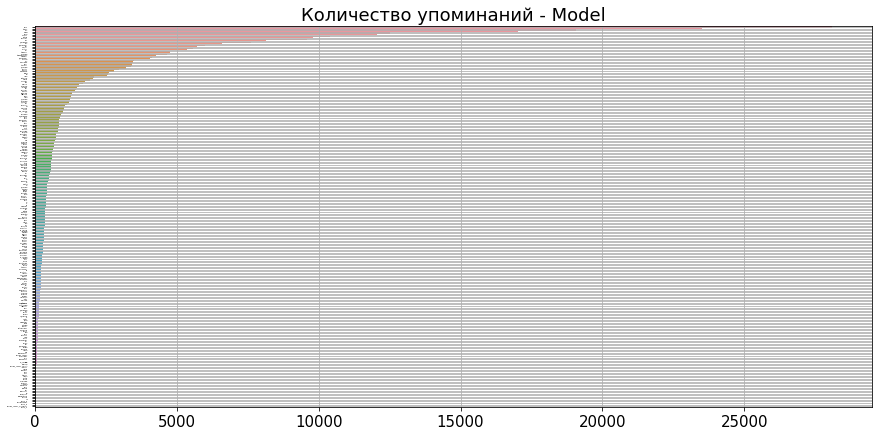

In [15]:
analysis(df, 'Model', 2)

Столбец **`Model`** содержит `17 тысяч` пропусков. 

Так как стобец **`Brand`** не содержал пропусков, попробуем заполнить пропуски **`Model`** используя привязку к существующим значениям столбца **`Brand`**

**Алгоритм следующий:**
- С помощью сводной таблицы считаем количество моделей по каждому бренду, изначально убираем модель `other`, чтобы она не размывала нам статистику.
- С помощью сортировки размещаем самую ходовую модель наверху списка группируя их по брендам.
- Генерируем таблицу самых популярных моделей **`popular_models`** внутри бренда, с помощью функции `first` в сводной таблице.

In [16]:
count_models_by_brand = df[df['Model'] != 'other'].pivot_table(index=['Brand', 'Model'],
                                                               values='Price',
                                                               aggfunc='count').reset_index()

sorted_model = count_models_by_brand.sort_values(by=['Brand', 'Price'], ascending=[True, False])
popular_models = sorted_model.pivot_table(index='Brand', values=['Model'], aggfunc='first')

In [17]:
popular_models.head()

,Model
Brand,
alfa_romeo,156
audi,a4
bmw,3er
chevrolet,matiz
chrysler,voyager


**Алгоритм заполнения пропусков:**
- Мерджим в новый столбец **`Model_y`** данные из нашего справочника **`popular_models`** по брендам.
- Через `.loc` оставляем только столбец **`Model`** со строками, сожержащие пропуски.
- Заполняем эти пропуски из нашего нового столбца **`Model_y`**.
- Оставшиеся **`NaN`** значения в столбце **`Model`** заполняем значением **`other`**
- Удаляем вспомогательный столбец **`Model_y`**

In [18]:
df = df.merge(popular_models, on='Brand', how='left', suffixes=('', '_y'))
df.loc[df['Model'].isna(), 'Model'] = df.loc[df['Model'].isna(), 'Model_y']
df['Model'] = df['Model'].fillna('other')
df = df.drop(columns='Model_y')

Проверим, что все ОК

In [19]:
print('Количество NaN:', df['Model'].isna().sum())
print(df['Model'].value_counts(dropna=False))

Количество NaN: 0
golf                  31143
other                 26200
3er                   20741
corsa                 13692
polo                  12511
                      ...  
i3                        8
serie_2                   8
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 250, dtype: int64


----

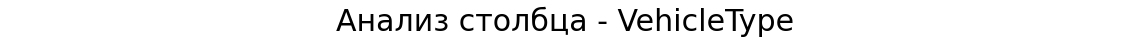

Тип данных в столбце: object


Количество пропусков: 32612
Доля пропусков: 9.6%


.describe()
count     308443
unique         8
top        sedan
freq       89087
Name: VehicleType, dtype: object


Количество упоминаний:
sedan          89087
small          77444
wagon          63465
NaN            32612
bus            28265
convertible    19817
coupe          15555
suv            11762
other           3048
Name: VehicleType, dtype: int64


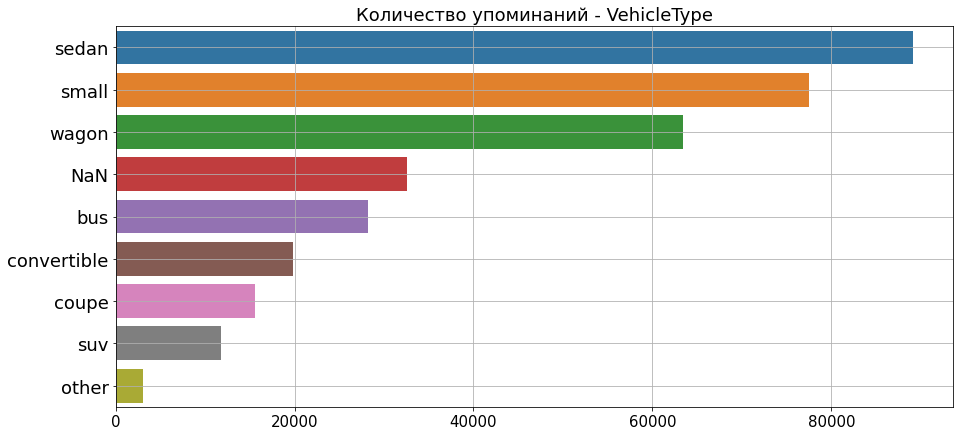

In [20]:
analysis(df, 'VehicleType')

В втолбце **`VehicleType`** больше `30 тысяч` пропусков, это `9.6%` от датасета.

Так как мы заполнили значениями столбец **`Model`**, используем его чтобы заполнить пропуски **`VehicleType`**. 

Алгоритм, будет схожий с **`Brand`** → **`Model`**:
- С помощью сводной таблицы считаем количество типов кузовов по каждой модели.
- С помощью сортировки размещаем самый ходовой кузов наверху списка группируя их по моделям.
- Генерируем таблицу самых популярных кузовов **`popular_types`** внутри модели, с помощью функции `first` в сводной таблице.

In [21]:
count_types_by_model = df.pivot_table(
    index=['Model', 'VehicleType'],
    values='Price',
    aggfunc='count').reset_index()

sorted_types = count_types_by_model.sort_values(by=['Model', 'Price'], ascending=[True, False])
popular_types = sorted_types.pivot_table(index='Model', values=['VehicleType'], aggfunc='first')

In [22]:
popular_types.head()

,VehicleType
Model,
100,sedan
145,small
147,sedan
156,sedan
159,wagon


**Алгоритм заполнения пропусков:**
- Мерджим в новый столбец **`VehicleType_y`** данные из нашего справочника **`popular_types`** по моделям.
- Через `.loc` оставляем только столбец **`VehicleType`** со строками, сожержащие пропуски.
- Заполняем эти пропуски из нашего нового столбца **`VehicleType_y`**.
- Оставшиеся **`NaN`** значения в столбце **`VehicleType`** заполняем значением **`other`**
- Удаляем вспомогательный столбец **`VehicleType_y`**

In [23]:
df = df.merge(popular_types, on='Model', how='left', suffixes=('', '_y'))
df.loc[df['VehicleType'].isna(), 'VehicleType'] = df.loc[df['VehicleType'].isna(), 'VehicleType_y']
df['VehicleType'] = df['VehicleType'].fillna('other')
df = df.drop(columns='VehicleType_y')

Проверим что все ОК

In [24]:
print('Количество NaN:', df['VehicleType'].isna().sum())
df['VehicleType'].value_counts(dropna=False)

Количество NaN: 0


sedan          104641
small           86977
wagon           67080
bus             31219
convertible     20028
coupe           15868
suv             12192
other            3050
Name: VehicleType, dtype: int64

-----

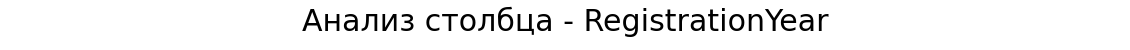

Тип данных в столбце: int64

Количество пропусков: 0
Доля пропусков: 0.0%


.describe()
count    341055.000000
mean       2003.955303
std          69.811742
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


Количество уникальных значений:
2000    22661
1999    21846
2005    21363
2006    19641
2001    19574
        ...  
2200        1
8888        1
2290        1
9450        1
1946        1
Name: RegistrationYear, Length: 138, dtype: int64


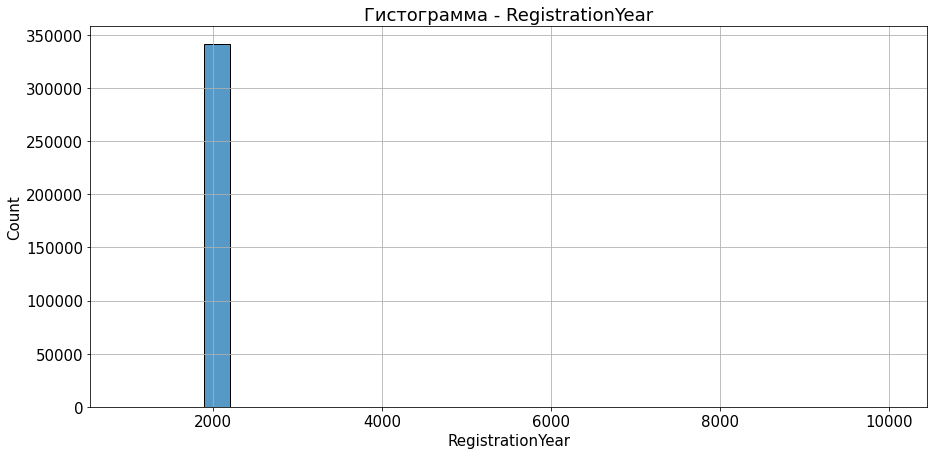

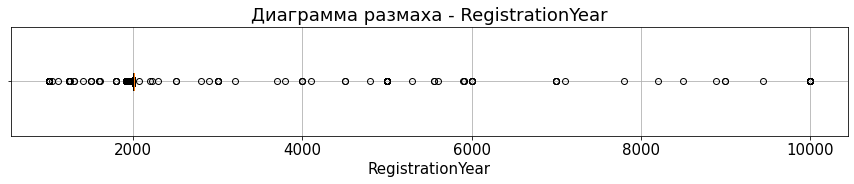

In [25]:
analysis(df, 'RegistrationYear')

Пропусков в столбце нет. Зато есть значения от `1000` до `9999`, что явно аномальные выбросы. 

Скорректируем нашу гистограмму, выведем ее по более реальному срезу. Значения возьмем от `1950` до `2022`

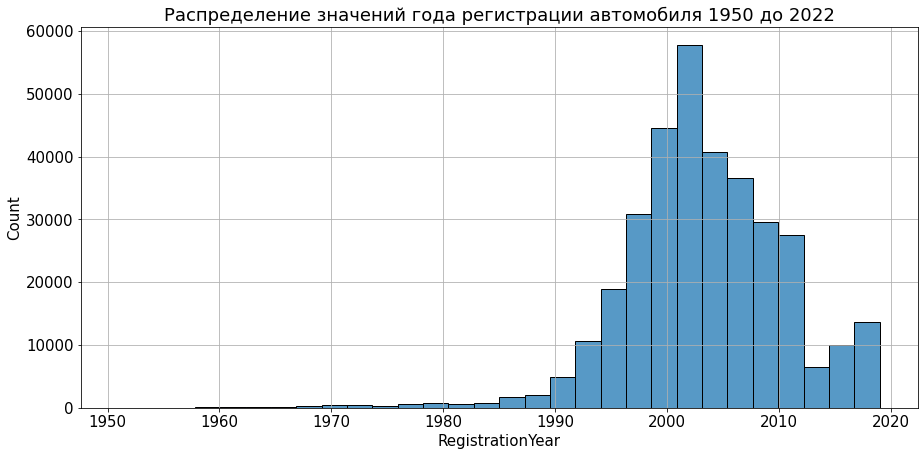

In [26]:
temp_slice = df[(df['RegistrationYear'] > 1950) & (df['RegistrationYear'] < 2022)]

plt.figure(figsize=(15,7))
sns.histplot(temp_slice['RegistrationYear'], bins=30)
plt.title('Распределение значений года регистрации автомобиля 1950 до 2022')
plt.grid()
plt.show()

Вот и адекватное распределение значений. С левого края оставим только автомобили, которые начали эксплуатировать с `1985` года. 

Чтобы понять где обрезать правый край, укрупним нашу гистограмму.

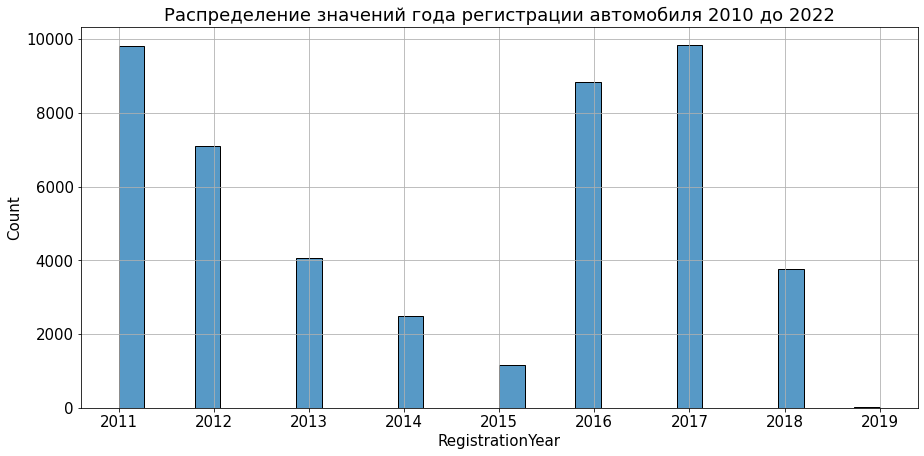

In [27]:
temp_slice = df[(df['RegistrationYear'] > 2010) & (df['RegistrationYear'] <= 2022)]

plt.figure(figsize=(15,7))
sns.histplot(temp_slice['RegistrationYear'], bins=30)
plt.title('Распределение значений года регистрации автомобиля 2010 до 2022')
plt.grid()
plt.show()

После `2018` года видим статистическую погрешность по количеству объявлений. Оставляем автомобили до `2018` года включительно.

Посмотрим на доли этих значений

In [28]:
part_calc(df[df['RegistrationYear'] < 1985])
part_calc(df[df['RegistrationYear'] > 2018])

Количество: 4855
Доля от изначального датасета: 1.37%

Количество: 87
Доля от изначального датасета: 0.02%



Можно удалять

In [29]:
df = df.drop(df[df['RegistrationYear'] < 1985].index)
df = df.drop(df[df['RegistrationYear'] > 2018].index)

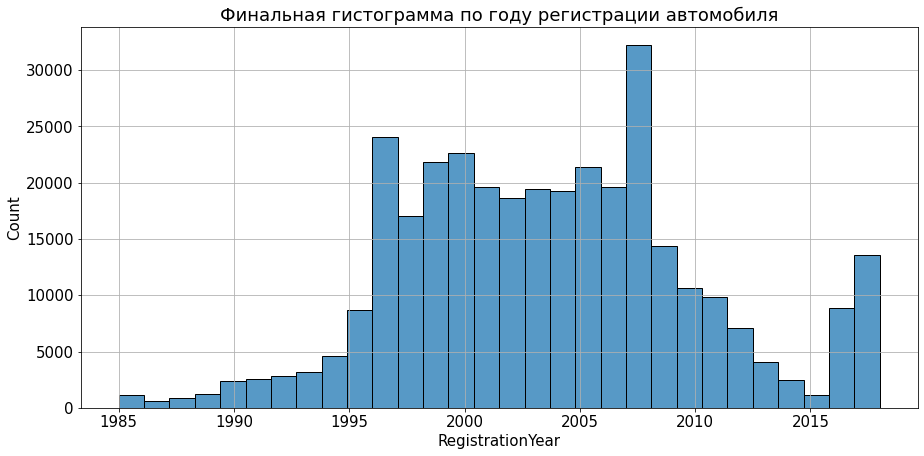

In [30]:
plt.figure(figsize=(15,7))
sns.histplot(df['RegistrationYear'], bins=30)
plt.title('Финальная гистограмма по году регистрации автомобиля')
plt.grid()
plt.show()

----

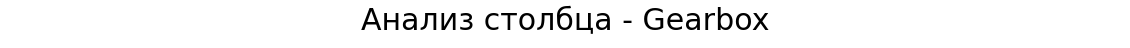

Тип данных в столбце: object


Количество пропусков: 15497
Доля пропусков: 4.6%


.describe()
count     320616
unique         2
top       manual
freq      256986
Name: Gearbox, dtype: object


Количество упоминаний:
manual    256986
auto       63630
NaN        15497
Name: Gearbox, dtype: int64


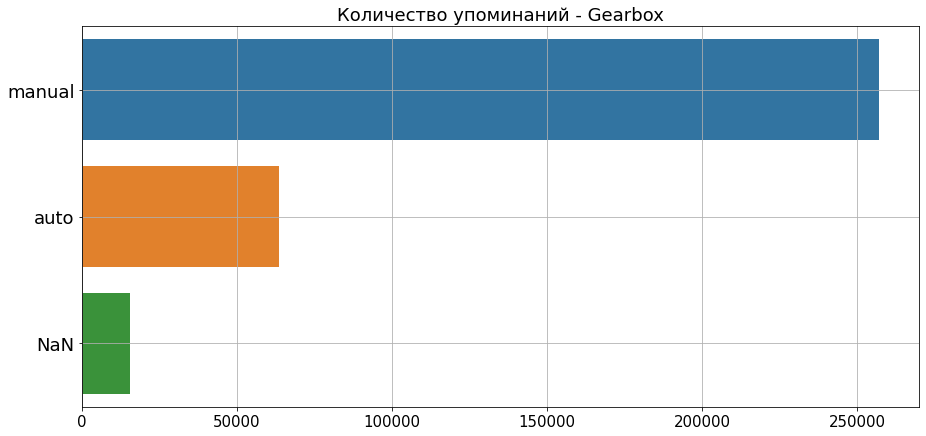

In [31]:
analysis(df, 'Gearbox')

Количество пропусков в типе трансмиссии `15 тысяч`, `4.6%` от датасета.

Процент пропусков не сильно большой, заполним пустые значения по следующей логике:
- Все авто до 2010 года - **`manual`**
- Все авто после 2010 года включительно - **`auto`**

In [32]:
df.loc[df['RegistrationYear'] < 2010, 'Gearbox'] = df.loc[df['RegistrationYear'] < 2010, 'Gearbox'].fillna('manual')
df.loc[df['RegistrationYear'] >= 2010, 'Gearbox'] = df.loc[df['RegistrationYear'] >= 2010, 'Gearbox'].fillna('auto')

Проверим результат

In [33]:
df['Gearbox'].value_counts(dropna=False)

manual    268932
auto       67181
Name: Gearbox, dtype: int64

----

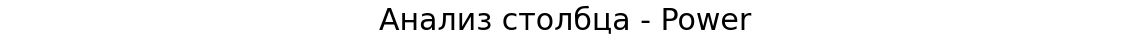

Тип данных в столбце: int64

Количество пропусков: 0
Доля пропусков: 0.0%


.describe()
count    336113.000000
mean        111.840438
std         187.367180
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


Количество уникальных значений:
0        33773
75       23033
60       15191
150      14053
101      12889
         ...  
17410        1
584          1
1054         1
851          1
1241         1
Name: Power, Length: 691, dtype: int64


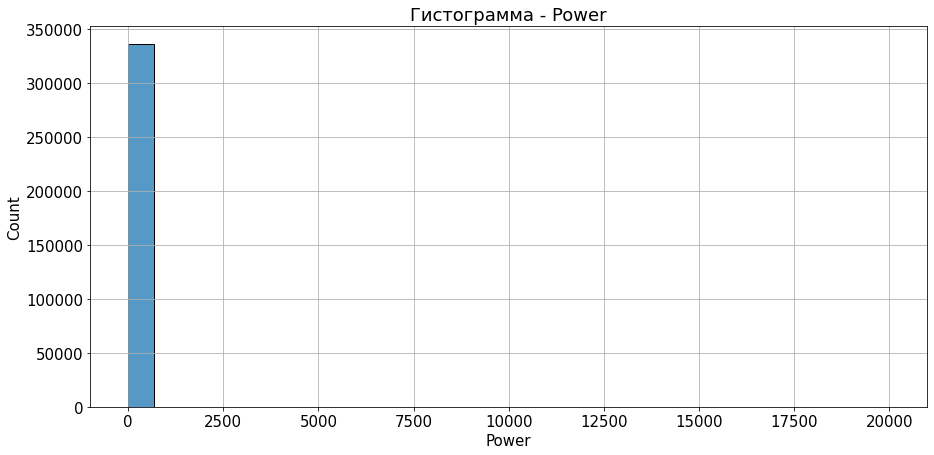

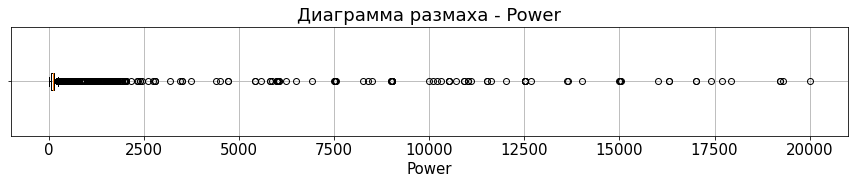

In [34]:
analysis(df, 'Power')

Сразу видно, что в мощности движка большое количество аномальных значений, данные плавают в диапазоне от `0` до `20000`

Срежем заведомо неадекватные значения и посмотрим на гистограмму поближе.

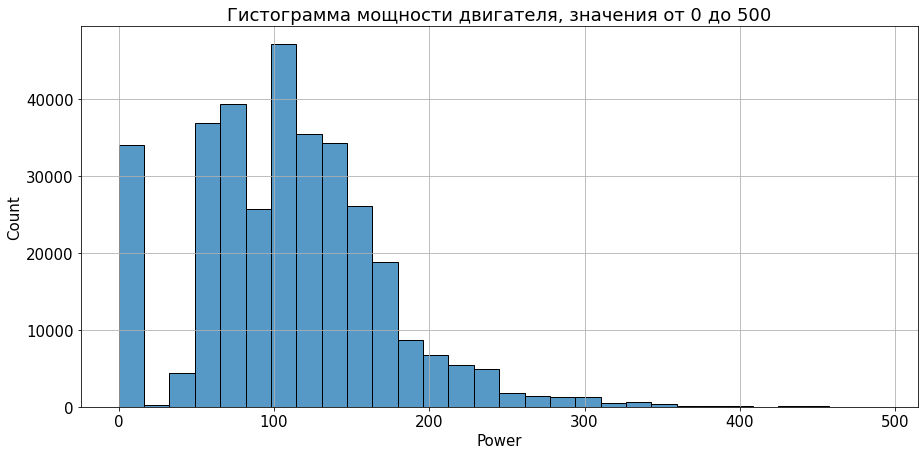

In [35]:
plt.figure(figsize=(15,7))
sns.histplot(df[df['Power'] < 500]['Power'], bins=30)
plt.title('Гистограмма мощности двигателя, значения от 0 до 500')
plt.grid()
plt.show()

Верхнюю границу мощности оставим на значении `400`

Теперь надо определиться, что делать с нижней границей, посмотрим на значения меньше `100` поближе

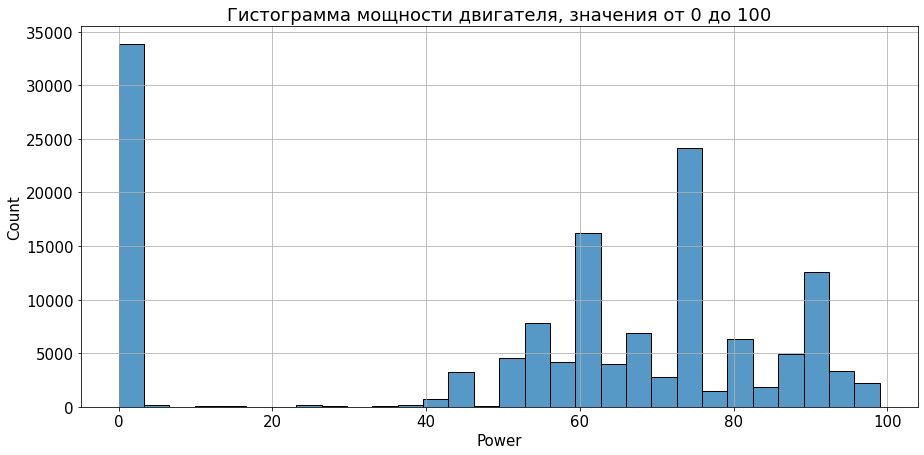

In [36]:
plt.figure(figsize=(15,7))
sns.histplot(df[df['Power'] < 100]['Power'], bins=30)
plt.title('Гистограмма мощности двигателя, значения от 0 до 100')
plt.grid()
plt.show()

Нижнюю границу мощности оставим на значении `50`. 

Теперь проверим доли значений.

In [37]:
part_calc(df[df['Power'] < 50])
part_calc(df[df['Power'] > 400])

Количество: 38708
Доля от изначального датасета: 10.92%

Количество: 672
Доля от изначального датасета: 0.19%



Значения выше `400` можем спокойно удалять, их менее `1%`, а вот со значениями ниже `50` мы не можем поступить так-же, там `10%` от датасета. 

Чтобы не потерять такое количество данных, заполним эти значения `средним` по столбцу **`Power`**, предварительно удалив оттуда значения выше `400`, чтобы у нас не поплыло среднее значение.

In [38]:
df = df.drop(df[df['Power'] > 400].index)

In [39]:
df['Power'].mean()

108.011042180294

In [40]:
df.loc[df['Power'] < 50, 'Power'] = int(df['Power'].mean())

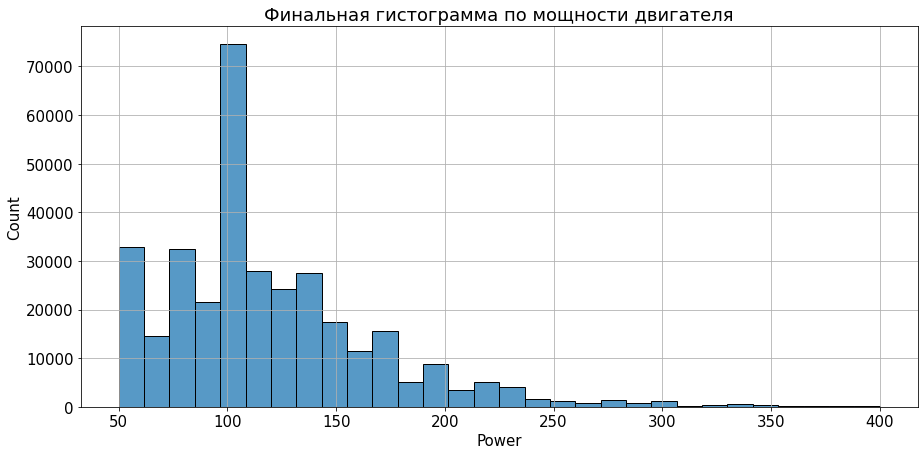

In [41]:
plt.figure(figsize=(15,7))
sns.histplot(df['Power'], bins=30)
plt.title('Финальная гистограмма по мощности двигателя')
plt.grid()
plt.show()

----

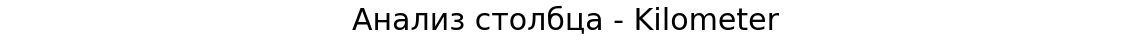

Тип данных в столбце: int64

Количество пропусков: 0
Доля пропусков: 0.0%


.describe()
count    335441.000000
mean     129018.754416
std       36702.121737
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


Количество уникальных значений:
150000    226830
125000     35123
100000     13811
90000      11101
80000       9587
70000       8213
60000       7143
50000       5927
40000       4699
5000        4241
30000       4157
20000       3635
10000        974
Name: Kilometer, dtype: int64


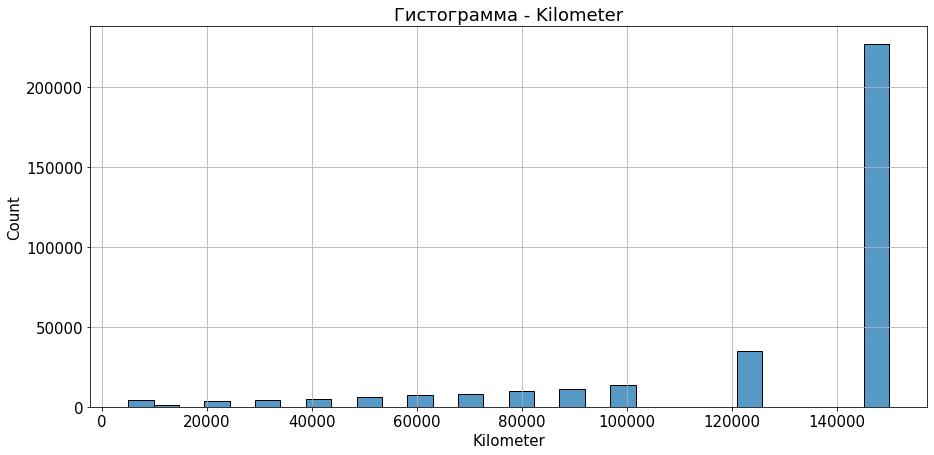

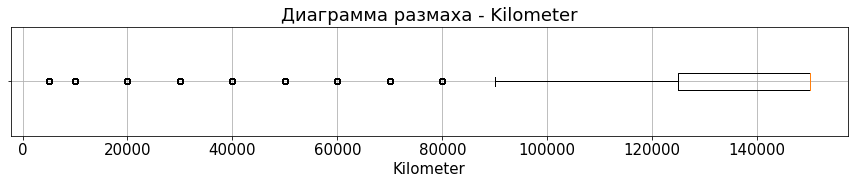

In [42]:
analysis(df, 'Kilometer')

С пробегом полный порядок. 

Так же можно отметить, что числовые данные имеют дискретные значения и скорей всего выбирались в какой то форме, а не заполнялись произвольным значением. Скорей всего это объясняет то, что в столбце нет ни аномальных значений, ни пропусков. Всегда бы так!

----

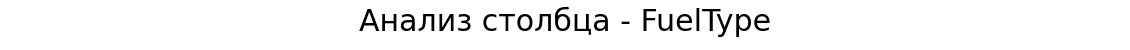

Тип данных в столбце: object


Количество пропусков: 27388
Доля пропусков: 8.2%


.describe()
count     308053
unique         7
top       petrol
freq      205449
Name: FuelType, dtype: object


Количество упоминаний:
petrol      205449
gasoline     96525
NaN          27388
lpg           5106
cng            542
hybrid         226
other          120
electric        85
Name: FuelType, dtype: int64


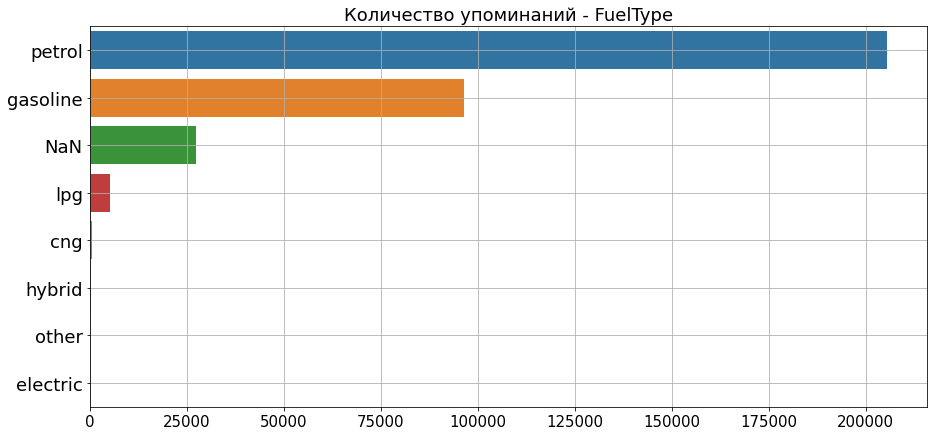

In [43]:
analysis(df,'FuelType')

В типе топлива у нас `27 тысяч` пропусков, `8.2%` от датасета.

Учитывая, что подавляющая часть автомобилей использует бензиновые двигатели, `8%` можно распределить на эти же значения.

In [44]:
df['FuelType'] = df['FuelType'].fillna('petrol')

Проверим что все ОК

In [45]:
print('Количество NaN:', df['FuelType'].isna().sum())
df['FuelType'].value_counts(dropna=False)

Количество NaN: 0


petrol      232837
gasoline     96525
lpg           5106
cng            542
hybrid         226
other          120
electric        85
Name: FuelType, dtype: int64

----

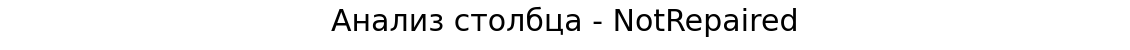

Тип данных в столбце: object


Количество пропусков: 62729
Доля пропусков: 18.7%


.describe()
count     272712
unique         2
top           no
freq      239771
Name: NotRepaired, dtype: object


Количество упоминаний:
no     239771
NaN     62729
yes     32941
Name: NotRepaired, dtype: int64


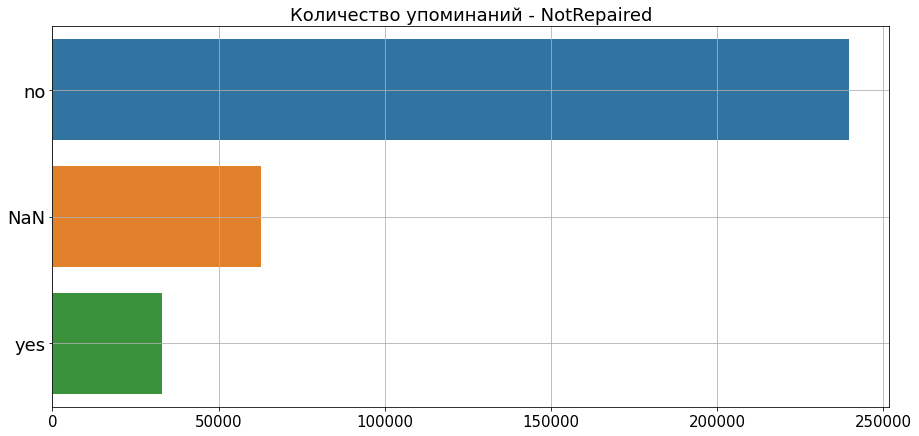

In [46]:
analysis(df,'NotRepaired')

Количество пропущенных значений `62 тысячи`, что `18.7%` от датасета. Такое количество удалить мы точно не можем, надо подумать по какому принципу можно заполнить эти пропуски.

Посмотрим на статистику ремонта в разрезе пробега

In [47]:
df.pivot_table(index='Kilometer', columns='NotRepaired', values='Price', aggfunc='count')

NotRepaired,no,yes
Kilometer,,
5000,1857,479
10000,809,46
20000,2858,241
30000,3527,207
40000,4118,168
50000,5124,258
60000,6165,314
70000,6934,395
80000,8011,530


Первое, что бросается в глаза, у нас как минимум `23398`, как бы это по мягче сказать, не очень добросовестных продавца. То, что автомобиль при пробеге `150000` ни разу не был в ремонте верится с трудом. Но оставим это на их совести. 

Заполним пропуски по следудующей логике:
- Пробег больше `100000` - автомобиль был в ремонте, то есть значение **`no`**
- Пробег меньше `100000` - автомобиль не был в ремонте, то есть значение **`yes`**

In [48]:
df.loc[df['Kilometer'] >= 100000, 'NotRepaired'] = df.loc[df['Kilometer'] >= 100000, 'NotRepaired'].fillna('no')
df.loc[df['Kilometer'] < 100000, 'NotRepaired'] = df.loc[df['Kilometer'] < 100000, 'NotRepaired'].fillna('yes')

Проверим, что все ОК

In [49]:
df['NotRepaired'].value_counts(dropna=False)

no     294597
yes     40844
Name: NotRepaired, dtype: int64

----

<a id='part_2_3'></a>
## 2.3 Обзор очищенного массива [▴](#head)


Общий вид


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,108,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,a4,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no



.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335441 entries, 0 to 341054
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             335441 non-null  int64 
 1   VehicleType       335441 non-null  object
 2   RegistrationYear  335441 non-null  int64 
 3   Gearbox           335441 non-null  object
 4   Power             335441 non-null  int64 
 5   Model             335441 non-null  object
 6   Kilometer         335441 non-null  int64 
 7   FuelType          335441 non-null  object
 8   Brand             335441 non-null  object
 9   NotRepaired       335441 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.2+ MB

Количество полных дубликатов: 55401


,Количество пропусков,Процент пропусков %
Price,0,0.0
VehicleType,0,0.0
RegistrationYear,0,0.0
Gearbox,0,0.0
Power,0,0.0
Model,0,0.0
Kilometer,0,0.0
FuelType,0,0.0
Brand,0,0.0
NotRepaired,0,0.0



.describe(числовых значений датафрейма)


,Price,RegistrationYear,Power,Kilometer
count,335441.000000,335441.000000,335441.000000,335441.000000
mean,4550.798969,2003.624831,119.877824,129018.754416
std,4487.601721,6.358213,48.811941,36702.121737
min,100.000000,1985.000000,50.000000,5000.000000
25%,1200.000000,1999.000000,88.000000,125000.000000
50%,2899.000000,2003.000000,108.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,2018.000000,400.000000,150000.000000



.describe(категориальных значений и дат)


,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
count,335441,335441,335441,335441,335441,335441
unique,8,2,248,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,102322,268601,30837,232837,72853,294597


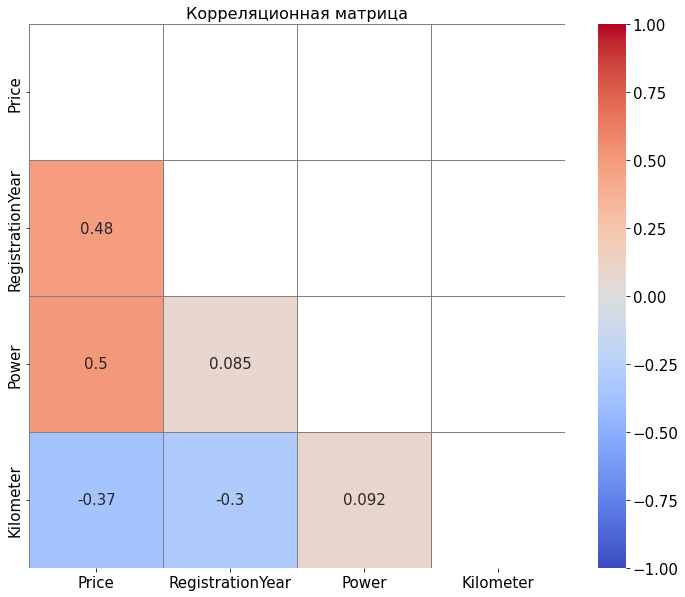

In [50]:
overview(df)

В обновленным датасете обнаружилось большое количество полных дубликатов. 

Удалим их.

In [51]:
print('Количество полных дубликатов:', df.duplicated().sum())
df = df.drop_duplicates()
print('Количество полных дубликатов:', df.duplicated().sum())

Количество полных дубликатов: 55401
Количество полных дубликатов: 0


Финальный взгляд на итоговый датасет для обучения

In [52]:
display(df)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,108,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,a4,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
341049,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
341051,2200,sedan,2005,manual,108,other,20000,petrol,sonstige_autos,yes
341052,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
341053,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


<a id='part_2_conclusions'></a>
## Выводы [▴](#head)

Мы привели в порядок все столбцы датасета. Посмотрим насколько сильно изменился его размер.

In [53]:
print(f'Исходный размер датасета: {df_raw.shape}')
print(f'Очищенный размер датасета: {df.shape}')
print(f'Потеря от исходного датасета по строкам: {1 - df.shape[0] / df_raw.shape[0]:.2%}')

Исходный размер датасета: (354369, 16)
Очищенный размер датасета: (280040, 10)
Потеря от исходного датасета по строкам: 20.98%


Потеряли `20%` данных, с учетом размера изначального датасета это не так критично.

Так же с учетом удаления аномалий, нормальный вид преобрела корреляционная матрица, вот о каких зависимостях она нам говорит:

**Корреляции относительно стоимости авто**

Корреляция|`Price`|Эффект
-|-|-
**`Kilometer`**|Слабая отрицательная|Выше пробег → Ниже цена
**`Power`**|Средняя положительная|Выше мощность → Выше цена
**`RegistrationYear`**|Средняя положительная|Моложе автомобиль → Выше цена

**Корреляции относительно возраста авто**

Корреляция|`RegistrationYear`|Эффект
-|-|-
**`Kilometer`**|Слабая отрицательная|Старее автомобиль → Выше пробег

<a id='part_3'></a>
# 3. Подготовка данных [▴](#head)

<a id='part_3_1'></a>
## 3.1 Кодирование категориальных признаков [▴](#head)

Так как количество категорий у нас около `300` штук, техника кодирования `OHE` нам не подойдет, потому что она создаст 300 столбцов с признаками и это окажет пагубное влияние на быстродействие некоторых моделей. 

По этому в нашем случае будем использовать технику `Ordinal Encoding`, с помощью которой текстовые признаки мы закодируем в определенное число.

In [54]:
encoder = OrdinalEncoder()

txt_columns = df.select_dtypes(include='object').columns # получаем список текстовых признаков

df_encoded = df.drop(columns=txt_columns) # создаем новый датасет. Для начала оставляем там только числовые признаки
df_encoded[txt_columns] = encoder.fit_transform(df[txt_columns]) # с помощью техники Ordinal Encoding, добавляем в 
                                                            # датафрейм df_encoded массив с закодированными признаками

df_encoded

,Price,RegistrationYear,Power,Kilometer,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,480,1993,108,150000,4.0,1.0,116.0,6.0,38.0,0.0
1,18300,2011,190,125000,2.0,1.0,29.0,2.0,1.0,1.0
2,9800,2004,163,125000,6.0,0.0,117.0,2.0,14.0,0.0
3,1500,2001,75,150000,5.0,1.0,116.0,6.0,38.0,0.0
4,3600,2008,69,90000,5.0,1.0,101.0,2.0,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...
341049,3200,2004,225,150000,4.0,1.0,140.0,6.0,30.0,1.0
341051,2200,2005,108,20000,4.0,1.0,166.0,6.0,33.0,1.0
341052,1199,2000,101,125000,1.0,0.0,106.0,6.0,32.0,0.0
341053,9200,1996,102,150000,0.0,1.0,222.0,2.0,38.0,0.0


<a id='part_3_2'></a>
## 3.2 Разбивка датасета на выборки [▴](#head)

Создаем `features` и `target` выборки

In [55]:
X = df_encoded.drop('Price', axis=1)
y = df_encoded['Price']

Делим выборки на `Тренировочную`, `Валидационную` и `Тестовую`

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    random_state=12345,
    test_size=0.4)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid, y_valid, 
    random_state=12345,
    test_size=0.5)

Проверяем

In [57]:
def part_of_df(X, y, title):
    print(f'\nДоля: {len(X) / len(df):.2f} | X: {X.shape} - {title}')
    print(f'Доля: {len(y) / len(df):.2f} | y: {y.shape} - {title}')

In [58]:
print('Размеры выборок:\n')

print(f'{df.shape} - df')

print(f'{X.shape} - X')
print(f'{y.shape} - y\n')

part_of_df(X_train, y_train, 'Тренировочные')
part_of_df(X_valid, y_valid, 'Валидационные')
part_of_df(X_test, y_test, 'Тестовые')

Размеры выборок:

(280040, 10) - df
(280040, 9) - X
(280040,) - y


Доля: 0.60 | X: (168024, 9) - Тренировочные
Доля: 0.60 | y: (168024,) - Тренировочные

Доля: 0.20 | X: (56008, 9) - Валидационные
Доля: 0.20 | y: (56008,) - Валидационные

Доля: 0.20 | X: (56008, 9) - Тестовые
Доля: 0.20 | y: (56008,) - Тестовые


<a id='part_4'></a>
# 4. Обучение моделей [▴](#head)

<a id='part_4_1'></a>
## 4.1 Подготовка к обучению [▴](#head)

Для автоматизации поиска лучших гиперпараметров напишем функцию **`auto_grid`**

**Принимает на вход:**
- модель
- параметры для модели

**Выдает:**
- Лучший score модели
- Набор гиперпараметров, на которых этот результат был получен

In [59]:
def auto_grid(search_model, params):
    grid_search = GridSearchCV(estimator=search_model,
                               param_grid=params,
                               cv=5,
                               scoring='neg_root_mean_squared_error',
                               n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    print(f'Лучший score модели: {grid_search.best_score_:.3f}')
    print(f'Параметры лучшей модели: {grid_search.best_params_}')

<a id='part_4_2'></a>
## 4.2 Decision Tree Regressor [▴](#head)

Прогоняем модель через `GridSearch`

In [60]:
model = DecisionTreeRegressor(random_state=12345)
params = {
    'max_depth': [15, 20, 30, 40],
    'min_samples_leaf': [9, 12, 15],
    'min_samples_split': [2, 3, 5]
}

In [61]:
# %%time
# auto_grid(model, params)
# print()

    Лучший score модели: -1898.201
    Параметры лучшей модели: {'max_depth': 40, 'min_samples_leaf': 12, 'min_samples_split': 2}
    
    Wall time: 13 s

Замеряем `время обучения` на валидационной выборке используя лучшие гиперпараметры из `GridSearch`

In [62]:
%%time
model_DT = DecisionTreeRegressor(max_depth=40,
                                 min_samples_leaf=12,
                                 min_samples_split=2,
                                 random_state=12345)

model_DT.fit(X_train, y_train)
print()


CPU times: total: 344 ms
Wall time: 343 ms


Замеряем `время предсказания` и проверяем `RMSE`

In [63]:
%%time
predicted = model_DT.predict(X_valid)

print(f'RMSE = {mean_squared_error(y_valid, predicted, squared=False):.3f}')
print()

RMSE = 1879.017

CPU times: total: 15.6 ms
Wall time: 16 ms


<a id='part_4_3'></a>
## 4.3 XGBoost [▴](#head)

Прогоняем модель через `GridSearch`

In [64]:
model = xgb.XGBRegressor(random_state=12345)
params = {'max_depth': [3, 6, 9],
          'n_estimators': [300, 400],
          'learning_rate': [0.1]}

In [65]:
# %%time
# auto_grid(model, params)
# print()

    Лучший score модели: -1632.172
    Параметры лучшей модели: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}
    
    Wall time: 2min 39s

Замеряем `время обучения` на валидационной выборке используя лучшие гиперпараметры из `GridSearch`

In [66]:
%%time
model_XGB = xgb.XGBRegressor(random_state=12345,
                             max_depth=9,
                             n_estimators=300,
                             learning_rate=0.1)

model_XGB.fit(X_train, y_train)
print()


CPU times: total: 2min 8s
Wall time: 10.8 s


Замеряем `время предсказания` и проверяем `RMSE`

In [67]:
%%time
predicted = model_XGB.predict(X_valid)
print(f'RMSE = {mean_squared_error(y_valid, predicted, squared=False):.3f}')
print()

RMSE = 1611.405

CPU times: total: 906 ms
Wall time: 85.8 ms


<a id='part_4_4'></a>
## 4.4 Light GBM [▴](#head)

Прогоняем модель через `GridSearch`

In [68]:
model = lgb.LGBMRegressor(random_state=12345)
params = {'max_depth': [6, 12, 20],
          'n_estimators': [500, 1000, 2000],
          'learning_rate': [0.1, 0.05, 0.01]}

In [69]:
# %%time
# auto_grid(model, params)
# print()

    Лучший score модели: -1623.977
    Параметры лучшей модели: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 2000}
    
    Wall time: 4min 53s

Замеряем `время обучения` на валидационной выборке используя лучшие гиперпараметры из `GridSearch`

In [70]:
%%time
model_LGBM = lgb.LGBMRegressor(random_state=12345,
                               learning_rate=0.1,
                               max_depth=20,
                               n_estimators=2000)

model_LGBM.fit(X_train, y_train)
print()


CPU times: total: 48.4 s
Wall time: 4.13 s
Parser   : 141 ms


Замеряем `время предсказания` и проверяем `RMSE`

In [71]:
%%time
predicted = model_LGBM.predict(X_valid)
print(f'RMSE = {mean_squared_error(y_valid, predicted, squared=False):.3f}')
print()

RMSE = 1598.903

CPU times: total: 8.41 s
Wall time: 708 ms


<a id='part_4_5'></a>
## 4.5 CatBoost [▴](#head)

Прогоняем модель через `GridSearch`

In [72]:
model = CatBoostRegressor(loss_function="RMSE", random_state=12345, verbose=False)
params = {'iterations': [250, 500, 1000],
          'depth': [5, 10, 15]}

In [73]:
# %%time
# auto_grid(model, params)
# print()

    Лучший score модели: -1632.218
    Параметры лучшей модели: {'depth': 10, 'iterations': 1000}
    
    Wall time: 21min 57s

Замеряем `время обучения` на валидационной выборке используя лучшие гиперпараметры из `GridSearch`

In [74]:
%%time

model_CB = CatBoostRegressor(loss_function="RMSE", 
                             iterations=1000,
                             depth=10,
                             random_state=12345,
                             verbose=False)

model_CB.fit(X_train, y_train)
print()


CPU times: total: 2min 11s
Wall time: 20.3 s


Замеряем `время предсказания` и проверяем `RMSE`

In [75]:
%%time
predicted = model_CB.predict(X_valid)
print(f'RMSE = {mean_squared_error(y_valid, predicted, squared=False):.3f}')
print()

RMSE = 1612.538

CPU times: total: 1.11 s
Wall time: 98.7 ms


<a id='part_4_6'></a>
## 4.6 Проверка моделей на адекватность [▴](#head)

Проверим предсказания наших моделей на адекватность используя **`DummyRegressor`**

In [76]:
model_D = DummyRegressor()
model_D.fit(X_train, y_train)
predicted = model_D.predict(X_valid)

print(f'RMSE = {mean_squared_error(y_valid, predicted, squared=False):.3f}')

RMSE = 4581.620


Результат `DummyRegressor` намного ниже чем у наших моделей. 

Можем считать, что наши модели обучились адекватно.

<a id='part_5'></a>
# 5. Анализ моделей [▴](#head)

<a id='part_5_1'></a>
## 5.1 Анализ на этапах предобработки [▴](#head)

В целях эксперимента, на каждом этапе предобработки прогоняли все наши модели через валидационную выборку на дефолтных настройках гиперпараметров.

In [77]:
steps = ['Датасет неочищен, удалены NaN',
         'Удал. аномалии - Price',
         'Удал. аномалии - RegistrationYear',
         'Удал. аномалии - Power',
         'Заполн. NaN - NotRepaired',
         'Заполн. NaN - FuelType',
         'Заполн. NaN - Model, VehicleType, Gearbox',
         'Удал. 55 тысяч дублей',
         'Модели откалиброваны']

model_scores = {'Decision Tree': [2437,2409,2350,2304,2265,2264,2390,2478,1879],
                'XGBoost': [1707,1633,1574,1550,1536,1543,1630,1711,1611],
                'Light GBM': [1738,1674,1619,1592,1592,1593,1677,1739,1598],
                'CatBoost': [1660,1592,1527,1510,1499,1501,1585,1667,1612]}

model_plot = pd.DataFrame(data=model_scores, index=steps)


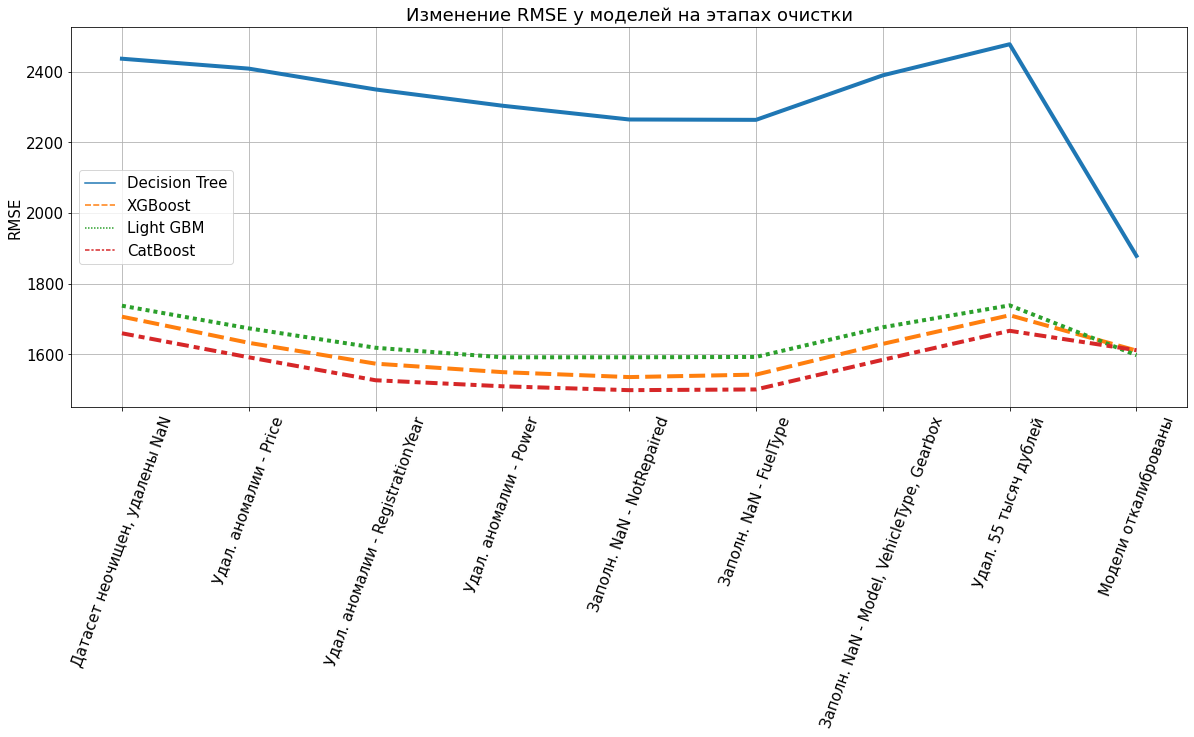

In [78]:
plt.figure(figsize=(20,7))
sns.lineplot(data=model_plot, linewidth=4.0)
plt.grid()
plt.xticks(rotation=70)
plt.ylabel('RMSE')
plt.title('Изменение RMSE у моделей на этапах очистки')
plt.show()

- По началу, с каждым этапом предобработки, качество наших моделей равномерно росло, но обусловлено это было тем, что вместе с очисткой датасета у нас росло количество дубликатов строк. Следовательно угадывать правильные ответы для модели было чисто статистически легче.
- После предобработки, когда мы удалили 55 тысяч дубликатов, качество моделей упало до начального уровня.
- После настройки гиперпараметров, качества `ДереваРешений` очень сильно выросло, однако до моделей бустинга не смогло добраться.
- Модели, которые используют градиентный бустинг, после настройки гиперпараметров, практически сравнялись по показателям качества. Однако в плане производительности показали сильно отличающиеся результаты. Подробнее в следующем пункте.



<a id='part_5_2'></a>
## 5.2 Анализ финальных моделей [▴](#head)

- После настройки гиперпараметров модели бустинга практически сравнялись по показателю качества, однако в плане времени обучения абсолютным лидером оказалась `LightGBM`, в 2 раза быстрее чем `XGBoost` и в 4 раза быстрее чем `CatBoost`
- Так же `LightGBM` обошла всех по показателю качества, хоть и немного.
- Время предсказания оказалось у всех моделей сильно меньше секунды, по этому считаю, что в критерии отбора лучшей модели этот показатель в нашем случае можно не учитывать.

Модель|RMSE|Время обучения (сек)|Время предсказания (сек)
-|-|-|-
DecisionTree|1879|0.373|0.017
LightGBM|1598|4.78|0.64
XGBoost|1611|11.5|0.112
CatBoost|1612|20.9|0.106

In [79]:
y_sp = [1879, 1598, 1611, 1612]
x_sp =[0.373, 4.78, 11.5, 20.9]
labels_sp = ['DecisionTree','LightGBM','XGBoost','CatBoost']
colors_sp = ['blue', 'orange', 'green', 'violet']

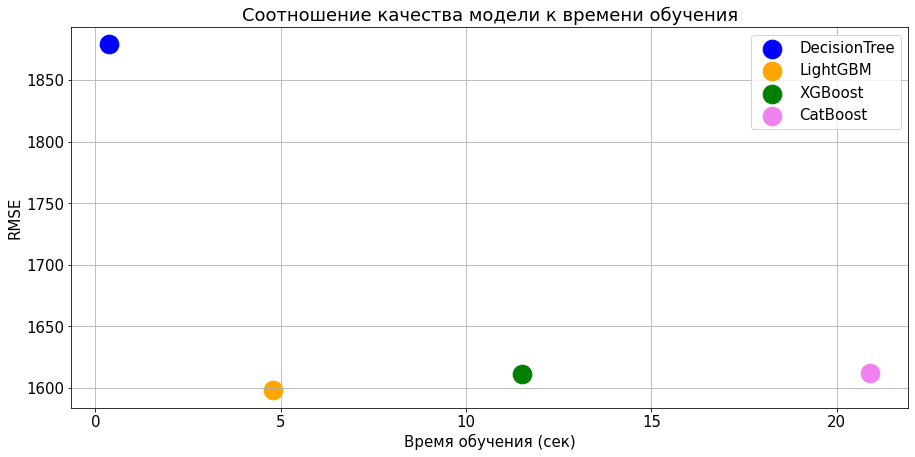

In [80]:
plt.figure(figsize=(15,7))

for i in range(4):
    plt.scatter(x_sp[i], 
                y_sp[i], 
                c=colors_sp[i], 
                s=350, 
                label=labels_sp[i])
plt.grid()
plt.legend()
plt.title('Соотношение качества модели к времени обучения')
plt.xlabel('Время обучения (сек)')
plt.ylabel('RMSE')
plt.show()

<a id='part_5_3'></a>
## 5.3 Тестирование лучшей модели [▴](#head)

Для финального тестирования выбираем модель `LightGBM`, самое время прогнать ее на тестовой выборке.

In [81]:
predicted = model_LGBM.predict(X_test)
print(f'RMSE = {mean_squared_error(y_test, predicted, squared=False):.3f}')
print()

RMSE = 1579.801



Результат оказался даже лучше чем на тестовой и валидационой выборке, что не может не радовать. Из этого можно сделать вывод, что наша модель не переобучилась и адекватно ведет себя на неизвестных данных.

<a id='part_5_conclusions'></a>
## Выводы [▴](#head)

- Основную сложность для нашего исследования оказали крайне грязные входные данные. 
- Датасет содержал большое количество: 
    - пропущенных значений
    - аномальных значений
    - дубликатов строк
- По итогу предобработки мы потеряли 20% от исходного датасета, что уменьшило его с `350 тыс.` строк до `280 тыс.`
- Для работы с категориальными данными мы выбрали способ преобразования `Ordinal Encoding` вместо `One Hot Encoding`, чтобы не плодить количество признаков до 300 штук, что оказало бы пагубное влияние на производительность обучения наших моделей.
- По итогу тестирования однозначным лидером по производительности и качеству оказалась модель `LightGBM` именно ее мы выберем для нашего заказчика.

<a id='check_list'></a>

## Чек-лист готовности проекта [▴](#head)

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей